In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf

from nltk.corpus import stopwords
from keras import backend as K
from keras import initializers, regularizers, constraints

seed = 1
np.random.seed(seed)
import warnings
import sys
if not sys.warnoptions:
  warnings.simplefilter("ignore")
#nltk.download('punkt')

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data_dir = "gdrive/My Drive/Colab Notebooks/FakeNews/"

train_stances = pd.read_csv(data_dir+'train_stances.csv')
train_bodies = pd.read_csv(data_dir+'train_bodies.csv')

In [4]:
print(train_stances.shape)
print(train_bodies.shape)

(49972, 3)
(1683, 2)


In [5]:
train_stances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [5]:
# Merging the stances and bodies with Body ID
train = pd.merge(train_stances, train_bodies, how='left', on='Body ID')

In [7]:
train.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [8]:
train.shape

(49972, 4)

In [6]:
target = ['agree', 'disagree', 'discuss', 'unrelated']
target_dict = dict(zip(target, range(len(target))))
f = lambda x: target_dict[x]
train['label'] = [f(train['Stance'][i]) for i in range(len(train['Stance']))]

In [10]:
train.head()

,Headline,Body ID,Stance,articleBody,label
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,3
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...,0
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...,3
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...,3
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's...",1


In [7]:
# Converting all the documents into lower case
train['Headline']= train['Headline'].apply(lambda x: x.lower())
train['articleBody']= train['articleBody'].apply(lambda x: x.lower())
train.head()

,Headline,Body ID,Stance,articleBody,label
0,police find mass graves with at least '15 bodi...,712,unrelated,danny boyle is directing the untitled film\n\n...,3
1,hundreds of palestinians flee floods in gaza a...,158,agree,hundreds of palestinians were evacuated from t...,0
2,"christian bale passes on role of steve jobs, a...",137,unrelated,30-year-old moscow resident was hospitalized w...,3
3,hbo and apple in talks for $15/month apple tv ...,1034,unrelated,(reuters) - a canadian soldier was shot at the...,3
4,spider burrowed through tourist's stomach and ...,1923,disagree,"fear not arachnophobes, the story of bunbury's...",1


In [12]:
train.isnull().sum().sum()

0

In [8]:
X_train = pd.DataFrame(train[['Headline', 'articleBody']])
y_train = train['label']

In [9]:
# Loading test data: competition_test data
test_stances = pd.read_csv(data_dir+'competition_test_stances.csv')
test_bodies = pd.read_csv(data_dir+'competition_test_bodies.csv')
test  = pd.merge(test_stances, test_bodies, how='left', on='Body ID')
test['label'] = [f(test['Stance'][i]) for i in range(len(test['Stance']))]

test['Headline']= test['Headline'].apply(lambda x: x.lower())
test['articleBody']= test['articleBody'].apply(lambda x: x.lower())

X_test = pd.DataFrame(test[['Headline', 'articleBody']])
y_test = test['label']

In [10]:
train_head_seq = [text_to_word_sequence(head) for head in train['Headline']]
train_body_seq = [text_to_word_sequence(body) for body in train['articleBody']]

test_head_seq = [text_to_word_sequence(head) for head in test['Headline']]
test_body_seq = [text_to_word_sequence(body) for body in test['articleBody']]

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
import nltk
#Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')

# Removes stopwords from given list of words or tokens
def remove_stopwords(text):
    return [i for i in text if i not in stopwords]

'''lst = pd.Series([['police', 'what', 'a', 'testing'], ['police', 'what', 'a', 'an']])
p = lst.apply(lambda x: remove_stopwords(x))
print(p)'''

train_head_seq_nsw = pd.Series(train_head_seq).apply(lambda x:remove_stopwords(x))
train_body_seq_nsw = pd.Series(train_body_seq).apply(lambda x:remove_stopwords(x))

test_head_seq_nsw = pd.Series(test_head_seq).apply(lambda x:remove_stopwords(x))
test_body_seq_nsw = pd.Series(test_body_seq).apply(lambda x:remove_stopwords(x))
#train_head_seq[0]

In [13]:
# Applying stemming for the training and test data samples
from nltk.stem import PorterStemmer
st = PorterStemmer()

def stem(docs):
  res = []
  for doc in docs:
    res.append([st.stem(word) for word in doc])
  return res

train_head_seq_nsw_st = stem(train_head_seq_nsw)
train_body_seq_nsw_st = stem(train_body_seq_nsw)

test_head_seq_nsw_st = stem(test_head_seq_nsw) 
test_body_seq_nsw_st = stem(test_body_seq_nsw)

print(train_head_seq_nsw_st[0])
print(train_head_seq_nsw[0])

['polic', 'find', 'mass', 'grave', 'least', "'15", "bodies'", 'near', 'mexico', 'town', '43', 'student', 'disappear', 'polic', 'clash']
['police', 'find', 'mass', 'graves', 'least', "'15", "bodies'", 'near', 'mexico', 'town', '43', 'students', 'disappeared', 'police', 'clash']


In [14]:
# Appending all words from headings and articleBody in the train data to the list_words
list_words = []

for i in range(len(train_head_seq_nsw)):   
    list_words.append(train_head_seq_nsw[i])

for i in range(len(train_body_seq_nsw)):
    list_words.append(train_body_seq_nsw[i])
    
print(len(list_words))

99944


In [15]:
# Building a tokenizer object from the list of words we have
special_chars = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words= 30000, filters = special_chars)

tokenizer.fit_on_texts([word for word in list_words])

print("Size of Vocabulary:", len(tokenizer.word_index))

Size of Vocabulary: 27717


In [16]:
# Now we need to maintain the len of the list
# Thus we extend the list by adding the words from the articleBody to the list with the words in the headings

train_seq = [list(i) for i in train_head_seq]

for i in range(len(train_head_seq)):
    train_seq[i].extend(train_body_seq[i])     
    
test_seq = [list(i) for i in test_head_seq]

for i in range(len(test_head_seq)):
    test_seq[i].extend(test_body_seq[i])

print(len(train_seq))

print(len(test_seq))

49972
25413


In [17]:
# Truncating all the words more than 128 words
X_train = tokenizer.texts_to_sequences([' '.join(seq[:128]) for seq in train_seq])

X_train = pad_sequences(X_train, maxlen = 128, padding = 'post', truncating = 'post')

y_train = train['label']

In [18]:
print(y_train.shape)

(49972,)


In [19]:
X_test = tokenizer.texts_to_sequences([' '.join(seq[:128]) for seq in test_seq])
X_test = pad_sequences(X_test, maxlen = 128, padding = 'post', truncating = 'post')
y_test = test['Stance']

In [20]:
# Encode the labels before transforming them to categorical

train_encode = LabelEncoder()
train_encode.fit(y_train)
train_encoded = train_encode.transform(y_train)
y_train = np_utils.to_categorical(train_encoded)

In [30]:
y_train[0:5]

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

In [21]:
seed = 9

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = seed, test_size = 0.1)

In [22]:
test_encode = LabelEncoder()
test_encode.fit(y_test)
test_encoded = test_encode.transform(y_test)

y_test = np_utils.to_categorical(test_encoded)

In [23]:
print("Shape of X_train:",X_train.shape)
print("Shape of X_test:",X_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)

Shape of X_train: (44974, 128)
Shape of X_test: (25413, 128)
Shape of y_train: (44974, 4)
Shape of y_test: (25413, 4)


In [24]:
# Creating word embeddings using the pretrained Glove model - 50d vectors
import gensim
inp = data_dir+'glove.twitter.27B.50d.txt'
out = data_dir+'glove.50d.txt.word2vec'

glove2word2vec(inp, out)

word_embeddings = gensim.models.KeyedVectors.load_word2vec_format(out, binary = False)

In [25]:
# Defining the weight matrix based on the embeddings

weight_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, 50)) 

for word, i in tokenizer.word_index.items():     
    try:
        word_embeddings_vector = word_embeddings[word]
        
    except KeyError:
        word_embeddings_vector = None

    if word_embeddings_vector is not None: 
        weight_matrix[i] = word_embeddings_vector
                

# Building a CNN model

In [ ]:
# Defining the CNN for training:

import keras
from keras.layers import Input, Dense, Embedding, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

keras.backend.clear_session()

model = Sequential()
model.add(Embedding(input_dim = len(tokenizer.word_index)+1, output_dim = 50, weights = [weight_matrix], trainable = True, input_length = 128))
model.add(Conv1D(256, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(4,activation ='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.save(data_dir+'models/CNN_final.h5')

In [ ]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_val, y_val))

Epoch 1/20
352/352 [==============================] - 109s 308ms/step - loss: 0.6523 - accuracy: 0.7602 - val_loss: 0.4644 - val_accuracy: 0.8243
Epoch 2/20
352/352 [==============================] - 108s 306ms/step - loss: 0.3715 - accuracy: 0.8614 - val_loss: 0.3534 - val_accuracy: 0.8617
Epoch 3/20
352/352 [==============================] - 110s 314ms/step - loss: 0.2531 - accuracy: 0.9044 - val_loss: 0.2786 - val_accuracy: 0.8944
Epoch 4/20
352/352 [==============================] - 108s 308ms/step - loss: 0.1899 - accuracy: 0.9292 - val_loss: 0.2792 - val_accuracy: 0.9010
Epoch 5/20
352/352 [==============================] - 108s 307ms/step - loss: 0.1433 - accuracy: 0.9471 - val_loss: 0.2249 - val_accuracy: 0.9190
Epoch 6/20
352/352 [==============================] - 121s 344ms/step - loss: 0.1127 - accuracy: 0.9582 - val_loss: 0.2217 - val_accuracy: 0.9224
Epoch 7/20
352/352 [==============================] - 108s 306ms/step - loss: 0.0930 - accuracy: 0.9664 - val_loss: 0.2405 -

In [26]:
import pickle

with open(data_dir+'models/'+'FNC_CNN.pickle', 'wb') as f:
    pickle.dump(history, f)

with open(data_dir+'models/'+'FNC_CNN.pickle', 'rb') as f:   
    history_loaded = pickle.load(f)

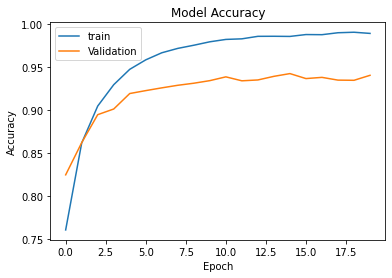

In [ ]:
# Accuracy Plot

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'Validation'])
plt.show()

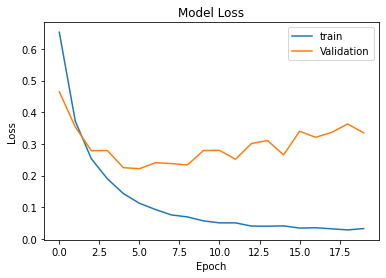

In [ ]:
# Loss Plot

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'Validation'])
plt.show()

In [ ]:
# Predict the stances for the test data

pred = model.predict(X_test)
predicted_labels = [np.argmax(p, axis = -1) for p in pred]
True_labels = [np.argmax(p, axis = -1) for p in y_test]

In [ ]:
# Convert the stances to the text stances

for i in range(len(predicted_labels)):
    if predicted_labels[i] == 0: predicted_labels[i] = "agree"
    if predicted_labels[i] == 1: predicted_labels[i] = "disagree"
    if predicted_labels[i] == 2: predicted_labels[i] = "discuss"
    if predicted_labels[i] == 3: predicted_labels[i] = "unrelated"

for i in range(len(True_labels)):
    if True_labels[i] == 0: True_labels[i] = "agree"
    if True_labels[i] == 1: True_labels[i] = "disagree"
    if True_labels[i] == 2: True_labels[i] = "discuss"
    if True_labels[i] == 3: True_labels[i] = "unrelated"

In [ ]:
test_df = pd.read_csv(data_dir+'competition_test_stances.csv')

In [ ]:
# Replacing the original stance labels with the predicted labels

pred_stance = predicted_labels
bodyid = []
headline = []

for i in range(len(test_df.Stance)):
    bodyid.append(test_df['Body ID'][i])
    headline.append(test_df['Headline'][i])

In [ ]:
df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": pred_stance})
df_submit.to_csv(data_dir+'models/'+'answer_CNN_Final.csv', index = False, encoding = 'utf-8')

In [ ]:
score, acc = model.evaluate(X_test, y_test, batch_size = 128)
print(acc)

199/199 [==============================] - 14s 69ms/step - loss: 2.5484 - accuracy: 0.7023
0.7023177146911621


# Model with Stacked LSTM

In [32]:
# Defining the LSTM model for training:

import keras
from keras.layers import Input, Dense, Embedding, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
keras.backend.clear_session()

# Stacked LSTM Model: Trainable = False to avoid overfitting on the train data
model = Sequential()
model.add(Embedding(input_dim = len(tokenizer.word_index)+1, output_dim = 50, weights = [weight_matrix], trainable = False, mask_zero = True)) 
model.add(Bidirectional(LSTM(120, return_sequences = False)))
model.add(Dropout(rate=0.35)) 
model.add(Activation(activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Activation(activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

In [33]:
history_s_lstm = model.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_val, y_val))

Epoch 1/20
352/352 [==============================] - 305s 827ms/step - loss: 0.7196 - accuracy: 0.7397 - val_loss: 0.6036 - val_accuracy: 0.7615
Epoch 2/20
352/352 [==============================] - 283s 805ms/step - loss: 0.5362 - accuracy: 0.7930 - val_loss: 0.4500 - val_accuracy: 0.8275
Epoch 3/20
352/352 [==============================] - 280s 797ms/step - loss: 0.4172 - accuracy: 0.8429 - val_loss: 0.3735 - val_accuracy: 0.8605
Epoch 4/20
352/352 [==============================] - 279s 792ms/step - loss: 0.3423 - accuracy: 0.8719 - val_loss: 0.3204 - val_accuracy: 0.8782
Epoch 5/20
352/352 [==============================] - 280s 794ms/step - loss: 0.2895 - accuracy: 0.8914 - val_loss: 0.2920 - val_accuracy: 0.8876
Epoch 6/20
352/352 [==============================] - 283s 803ms/step - loss: 0.2465 - accuracy: 0.9092 - val_loss: 0.2671 - val_accuracy: 0.8974
Epoch 7/20
352/352 [==============================] - 279s 792ms/step - loss: 0.2176 - accuracy: 0.9186 - val_loss: 0.2636 -

In [36]:
import pickle
with open(data_dir+'FNC_Bidirectional_LSTM_stacked_processed.pickle', 'wb') as f:    
    pickle.dump(history_s_lstm, f)  
    
with open(data_dir+'FNC_Bidirectional_LSTM_stacked_processed.pickle', 'rb') as f:
    history_s_lstm_loaded = pickle.load(f)

INFO:tensorflow:Assets written to: ram://1f060b87-8020-49f5-8333-c1280ec86e0d/assets


INFO:tensorflow:Assets written to: ram://1f060b87-8020-49f5-8333-c1280ec86e0d/assets


In [35]:
model.save(data_dir+'models/BiLSTM_processed.h5')

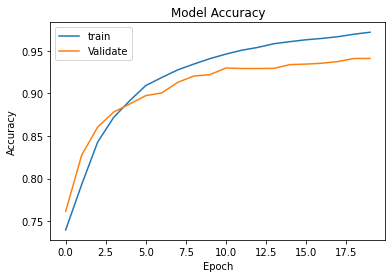

In [37]:
# Accuracy Plot
plt.plot(history_s_lstm_loaded.history['accuracy'])
plt.plot(history_s_lstm_loaded.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'Validate'])
plt.show()

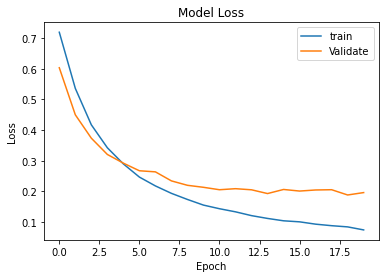

In [38]:
# Loss Plot

plt.plot(history_s_lstm_loaded.history['loss'])
plt.plot(history_s_lstm_loaded.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'Validate'])
plt.show()

In [39]:
# Predict the stances for the test data

pred_lstm = model.predict(X_test)
predicted_labels_lstm = [np.argmax(p, axis = -1) for p in pred_lstm]
True_labels = [np.argmax(p, axis = -1) for p in y_test]

In [40]:
# Convert the stances to the text stances

for i in range(len(predicted_labels_lstm)):
    if predicted_labels_lstm[i] == 0: predicted_labels_lstm[i] = "agree"
    if predicted_labels_lstm[i] == 1: predicted_labels_lstm[i] = "disagree"
    if predicted_labels_lstm[i] == 2: predicted_labels_lstm[i] = "discuss"
    if predicted_labels_lstm[i] == 3: predicted_labels_lstm[i] = "unrelated"

for i in range(len(True_labels)):
    if True_labels[i] == 0: True_labels[i] = "agree"
    if True_labels[i] == 1: True_labels[i] = "disagree"
    if True_labels[i] == 2: True_labels[i] = "discuss"
    if True_labels[i] == 3: True_labels[i] = "unrelated"

In [41]:
test_df = pd.read_csv(data_dir+'competition_test_stances.csv')

# Replacing the original stance labels with the predicted labels

pred_stance = predicted_labels_lstm
bodyid = []
headline = []
for i in range(len(test_df.Stance)):
    bodyid.append(test_df['Body ID'][i])
    headline.append(test_df['Headline'][i])

df_submit = pd.DataFrame( data = {'Headline': headline, 'Body ID': bodyid, "Stance": pred_stance})

In [46]:
df_submit.to_csv(data_dir+'answer_LSTM_Stacked_processed_Final.csv', index = False, encoding = 'utf-8')

In [42]:
score, acc = model.evaluate(X_test, y_test, batch_size = 128)
print("Test Accuracy with LSTM:", acc)

199/199 [==============================] - 47s 237ms/step - loss: 1.4643 - accuracy: 0.7207
Test Accuracy with LSTM: 0.7207334637641907
